# Compare EUV & Lx_sat calc (LoFo14 & ChRo16)

In [2]:
!pwd

/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/example


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from astropy import constants as const
import multiprocessing
import random
import time
from matplotlib.ticker import FuncFormatter

if os.path.exists("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/"):
    sys.path.append("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/")
elif os.path.exists("/work2/lketzer/work/gitlab/platypos_group/platypos/"):
    sys.path.append("/work2/lketzer/work/gitlab/platypos_group/platypos/")
elif os.path.exists("/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/"):
    sys.path.append("/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/")
import platypos
from platypos import Planet_LoFo14
from platypos import Planet_ChRo16
from platypos import Planet_Ot20
import platypos.planet_models_LoFo14 as plmoLoFo14
import platypos.planet_models_ChRo16 as plmoChRo16
from platypos.mass_evolution_function import mass_evo_RK4_forward
from platypos.mass_loss_rate_function import mass_loss_rate, mass_loss_rate_Elim, mass_loss_rate_RRlim, mass_loss_rate_noplanetobj
from platypos.lx_evo_and_flux import lx_evo, flux_at_planet, l_xuv_all
from platypos.mass_luminosity_relation import mass_lum_relation_mamajek, mass_lum_relation_thomas
from platypos.lx_evo_and_flux import l_high_energy

if os.path.exists("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/"):
    sys.path.append("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/")
elif os.path.exists("/work2/lketzer/work/gitlab/platypos_group/multitrack/"):
    sys.path.append("/work2/lketzer/work/gitlab/platypos_group/multitrack/")
elif os.path.exists("/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/"):
    sys.path.append("/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/")

from multitrack import evolve_one_planet_along_one_track
#from multitrack import evolve_one_planet
from multitrack.create_planet_chunks import create_file_structure_for_saving_results_and_return_planet_folder_pairs
from multitrack.create_planet_chunks import make_folder_planet_track_list
from multitrack.create_planet_chunks import create_arg_list_one_planet, create_arg_list_one_planet_along_one_track

from multitrack.evolve_planet import evolve_1planet_1track
from multitrack.create_planet_chunks import create_arg_list_1planet_1track
from multitrack.complete_track_dict import complete_track_dict, complete_track_dict_noplobj

from multitrack.read_in_PLATYPOS_population_results import read_results_file, read_in_PLATYPOS_results_fullEvo
from multitrack.read_in_PLATYPOS_population_results import read_in_PLATYPOS_results_final
from multitrack.read_in_PLATYPOS_population_results import read_in_PLATYPOS_results_dataframe
from multitrack.read_in_PLATYPOS_population_results import get_complete_results
from multitrack.read_in_PLATYPOS_population_results import read_in_host_star_parameters
from multitrack.read_in_PLATYPOS_population_results import read_in_PLATYPOS_results_df_new, create_master_table

import multitrack.keplers_3rd_law as kepler3
import multitrack.get_ExoplanetEU_data as exoEU


#!pip install line_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 2


def calculate_envelope_mass_fract_distro_Gupta19(mass_core):
    X = 0.05 * mass_core**(1/2)
    f = 1 / (1/X + 1) * 100 # in %
    return f, X

def calculate_envelope_mass_fract_distro_Morda20(mass_core, a):
    mass_envelope = 0.024 * mass_core**2.23 * a**0.72
    f = (mass_envelope / (mass_envelope + mass_core)) * 100 # in %
    X = mass_envelope / mass_core
    return f, X

def calculate_envelope_mass_fract_distro_LeCh15(mass_core, a):
    mass_envelope = 0.016 * mass_core**2.6 * a**0.95
    f = (mass_envelope / (mass_envelope + mass_core)) * 100 # in %
    X = mass_envelope / mass_core
    return f, X

# OLD!!
# track parameters which are different between the diff. tracks: t_sat, dt_drop, Lx_drop_factor
# track1 = {'t_sat': 1.9513432987716333, 'dt_drop': 23.3, 'Lx_drop_factor': 37.657876399021}
# track2 = {'t_sat': 4.097848550067654, 'dt_drop': 23.3, 'Lx_drop_factor': 32.93517012357806}
# track3 = {'t_sat': 8.605539963092262, 'dt_drop': 23.3, 'Lx_drop_factor': 25.645501139747335}
# track4 = {'t_sat': 18.071755740010293, 'dt_drop': 23.3, 'Lx_drop_factor': 16.73703522599636}
# track5 = {'t_sat': 37.95094287253076, 'dt_drop': 23.3, 'Lx_drop_factor': 8.785921912518194}
# track6 = {'t_sat': 79.69751725480509, 'dt_drop': 23.3, 'Lx_drop_factor': 3.7416155266187654}
# track7 = {'t_sat': 167.36591440992555, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
# track8 = {'t_sat': 351.47078944396685, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
# track9 = {'t_sat': 500.0, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
# track10 = {'t_sat': 100.0, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
# different_track_params_list = [track3, track7]#, track2, track3, track4, track5, track6, track7, track8, track9, track10]

# updated tracks 19.4.2021
# track parameters which are different between the diff. tracks: t_sat, dt_drop, Lx_drop_factor
track1 = {'t_sat': 3.0, 'dt_drop': 23.3, 'Lx_drop_factor': 24.06864689032241}
track2 = {'t_sat': 5.686595649127654, 'dt_drop': 23.3, 'Lx_drop_factor': 20.76936880755305}
track3 = {'t_sat': 10.779123358892523, 'dt_drop': 23.3, 'Lx_drop_factor': 16.25091979467301}
track4 = {'t_sat': 20.4321719980295, 'dt_drop': 23.3, 'Lx_drop_factor': 11.13527177810566}
track5 = {'t_sat': 38.729833462074154, 'dt_drop': 23.3, 'Lx_drop_factor': 6.55552488262853}
track6 = {'t_sat': 73.41363415228984, 'dt_drop': 23.3, 'Lx_drop_factor': 3.343758137163314}
track7 = {'t_sat': 139.15788418568704, 'dt_drop': 23.3, 'Lx_drop_factor': 1.5233608892285553}
track8 = {'t_sat': 263.7782062507126, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
track9 = {'t_sat': 500.0, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
track10 = {'t_sat': 100.0, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
different_track_params_list_old = [track1, track2, track3, track4, track5, track6, track7, track8, track9, track10]

# updated tracks 6.10.2021
# updated tracks adjusted to Johnstone20 & Jackson12       
track1 = {'t_sat': 3.0, 'dt_drop': 23.3, 'Lx_drop_factor': 19.885367123647562}
track2 = {'t_sat': 5.686595649127654, 'dt_drop': 23.3, 'Lx_drop_factor': 17.307102833587724}
track3 = {'t_sat': 10.779123358892523, 'dt_drop': 23.3, 'Lx_drop_factor': 13.73623752963638}
track4 = {'t_sat': 20.4321719980295, 'dt_drop': 23.3, 'Lx_drop_factor': 9.621150811325675}
track5 = {'t_sat': 38.729833462074154, 'dt_drop': 23.3, 'Lx_drop_factor': 5.84115622618472}
track6 = {'t_sat': 73.41363415228984, 'dt_drop': 23.3, 'Lx_drop_factor': 3.098196065725634}
track7 = {'t_sat': 139.15788418568704, 'dt_drop': 23.3, 'Lx_drop_factor': 1.4774377415503037}
track8 = {'t_sat': 263.7782062507126, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
track9 = {'t_sat': 500.0, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
track10 = {'t_sat': 100.0, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
different_track_params_list_new = [track1, track2, track3, track4, track5, track6, track7, track8, track9, track10]

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compare Elim vs RRlim

In [34]:
kepler3.get_a_from_period_no_Mpl(1.0, 100)

0.42163279372300405

In [46]:
age_star = age = 10.
mass_star_arr = [1.0]
m_core_arr = np.logspace(np.log10(1), np.log10(20), 10)
a_arr = np.logspace(np.log10(0.05), np.log10(0.42), 10)

list_planets_LoFo = []
list_planets_ChRo = []
for m_star in mass_star_arr:
    Lbol = 10**mass_lum_relation_mamajek()(m_star)
    star = {'star_id': "dummy", 'mass': m_star, 'radius': None, 'age': age,
            'L_bol': Lbol,
            'Lx_age': l_high_energy(t_=1.0, mass_star=m_star, paper='Tu15')}
    for a in a_arr:
        for m_core in m_core_arr:
            fenv, _ = calculate_envelope_mass_fract_distro_Morda20(m_core, a)
            #print(fenv)
            planet = {'distance': a, 'fenv': fenv, 'core_mass': m_core}
            pl = Planet_ChRo16(star, planet)
            pl_ = Planet_LoFo14(star, planet)
            pl.Lx_sat_info = "Tu15"
            pl_.Lx_sat_info = "Tu15"
            list_planets_LoFo.append(pl_)
            list_planets_ChRo.append(pl)

In [48]:
len(list_planets_ChRo)

100

# Evolve planet sample through both tracks

In [138]:
t_final, initial_step_size, epsilon = 7000., 0.1, 0.1
K, beta_settings = "yes", {"beta_calc": "Lopez17", "RL_cut": True}
mass_loss_calc = "RRlim"#"Elim_and_RRlim"
Lx1Gyr = "Jackson12"
ML_rel = "ZAMS_Thomas"
fenv_sample_cut = True
relation_EUV = 'Johnstone'
Lx1Gyr = "Jackson12"

path = os.path.join(os.getcwd(), "Updated_Tracks_061021_test_masslossrates")

different_track_params_list = [different_track_params_list_new[i] for i in [1,4,7]]



In [139]:
for list_planets in [list_planets_ChRo]:
    if list_planets[0].planet_type == 'ChRo16':
        name1 = 'ChRo16'
    else:
        name1 = "LoFo14"

    if fenv_sample_cut == True:
        name2 = "_fenvCut_True_"
    else:
        name2 = "_fenvCut_False_"

    name3 = relation_EUV
    name4 = "_" + Lx1Gyr 

    name = name1 + name2 + name3 + name4 + "_" + mass_loss_calc + "/"

    if not os.path.isdir(os.path.join(path, name)):
        os.makedirs(os.path.join(path, name))
    else:
        print(name + " exists.")
        pass
        #os.system("rm -r " + os.getcwd() + "/" + name)
        #os.makedirs(os.getcwd() + "/" + name)

    path_save, folder_planet_list = create_file_structure_for_saving_results_and_return_planet_folder_pairs(
                                                curr_path=path+"/",
                                                folder_name=name,
                                                list_planets=list_planets)
    print("\nPath for saving results:\n", path_save)
    
    # create list of [folder, planet, track]-triplets
    folder_planet_track_list =  make_folder_planet_track_list(
                                                        folder_planet_list,
                                                        different_track_params_list)

    # for evolve_one_planet_along_one_track
    arg_tuples = create_arg_list_1planet_1track(
                                    folder_planet_track_list,
                                    t_final,
                                    initial_step_size,
                                    epsilon, K, beta_settings,
                                    path_save,
                                    relation_EUV,
                                    mass_loss_calc,
                                    fenv_sample_cut,
                                    ML_rel,
                                    Lx1Gyr)

    start = time.time()
    if __name__ == '__main__': # Allows for the safe importing of the main module

        cpu_count = multiprocessing.cpu_count()
        print("There are %d CPUs on this machine" % cpu_count)

        with multiprocessing.Pool(processes=cpu_count-1) as pool:
            pool.starmap(evolve_1planet_1track, arg_tuples)

    print(f'Time (min): {(time.time() - start)/60}')
    print("\n")

Folder ChRo16_fenvCut_True_Johnstone_Jackson12_RRlim/ exists.

Path for saving results:
 /home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/example/Updated_Tracks_061021_test_masslossrates/ChRo16_fenvCut_True_Johnstone_Jackson12_RRlim/
There are 8 CPUs on this machine
Time (min): 0.6931086540222168




In [51]:
path_save = path+"/"

add_parameters = {"epsilon": epsilon,
                  "beta_settings": beta_settings,
                  "K_on": K,
                  "mass_loss_calc": mass_loss_calc,
                  "relation_EUV": relation_EUV}

###
f = "ChRo16_fenvCut_True_Johnstone_Jackson12_Elim_and_RRlim/"
pl_ChRo_ER, tracks_dict_n = read_in_PLATYPOS_results_df_new(path_save+f, len(different_track_params_list), return_second_to_last=False)
pl_ChRo_ER_more = create_master_table(pl_ChRo_ER, path_save+f, len(different_track_params_list), add_parameters)
pl_df_dict_ChRo_ER, pl_init_dict_ChRo_ER, track_dict = read_in_PLATYPOS_results_fullEvo(path_save+f, len(different_track_params_list))

/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/example/Updated_Tracks_061021_test_masslossrates/ChRo16_fenvCut_True_Johnstone_Jackson12_Elim_and_RRlim/
Total # of planet folders =  100
Non-empty folders:  100

Total number of planets to analyze:  100
Non-empty folders:  100
/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/example/Updated_Tracks_061021_test_masslossrates/ChRo16_fenvCut_True_Johnstone_Jackson12_Elim_and_RRlim/
Total # of planet folders =  100
Non-empty folders:  100

Total number of planets to analyze:  100


In [144]:
path_save = path+"/"

add_parameters = {"epsilon": epsilon,
                  "beta_settings": beta_settings,
                  "K_on": K,
                  "mass_loss_calc": mass_loss_calc,
                  "relation_EUV": relation_EUV}

###
f = "ChRo16_fenvCut_True_Johnstone_Jackson12_RRlim/"
pl_ChRo_RR, tracks_dict_n = read_in_PLATYPOS_results_df_new(path_save+f, len(different_track_params_list), return_second_to_last=False)
pl_ChRo_RR_more = create_master_table(pl_ChRo_RR, path_save+f, len(different_track_params_list), add_parameters)
pl_df_dict_ChRo_RR, pl_init_dict_ChRo_ER, track_dict = read_in_PLATYPOS_results_fullEvo(path_save+f, len(different_track_params_list))

/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/example/Updated_Tracks_061021_test_masslossrates/ChRo16_fenvCut_True_Johnstone_Jackson12_RRlim/
Total # of planet folders =  100
Non-empty folders:  100

Total number of planets to analyze:  100
Non-empty folders:  100
/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/example/Updated_Tracks_061021_test_masslossrates/ChRo16_fenvCut_True_Johnstone_Jackson12_RRlim/
Total # of planet folders =  100
Non-empty folders:  100

Total number of planets to analyze:  100


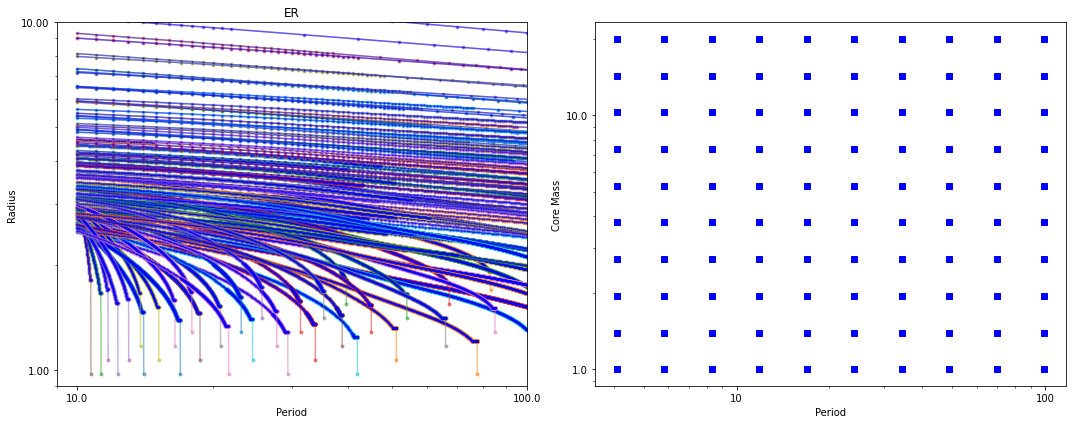

In [145]:
pl_df_dict = pl_df_dict_ChRo_RR
pl_df_more = pl_ChRo_RR_more 
track = 2

###
planets_with_RRlim = []
planets_without_RRlim = []

fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].set_title("ER")

for p in planet_ids:
    planet = pl_df_dict[p]
    lvi = planet["t"+str(track)].last_valid_index()
    planet = pl_df_dict[p].loc[:lvi]
    
    t = planet["t"+str(track)]
    R = planet["R"+str(track)]
    axs[0].plot(t, R, marker=".", alpha=0.5)
    
    mask_Elim = planet[f"Mdot_info{track}"].str.contains("Elim")
    mask_RRlim = planet[f"Mdot_info{track}"].str.contains("RRlim")
    
    axs[0].plot(t[mask_Elim], R[mask_Elim], marker="s", alpha=0.5, color="k", markersize=1)
    axs[0].plot(t[mask_RRlim], R[mask_RRlim], marker="s", alpha=0.5, color="blue", markersize=1)

    if sum(mask_RRlim) > 1:
        planets_with_RRlim.append((p, planet))
    else:
        planets_without_RRlim.append((p, planet))
    
# R = pl_ChRo_ER_more["R"+str(track)]
# P = pl_ChRo_ER_more["period"]
# axs[0].plot(P, R, marker=".", ls="None", color="b")
ylim = axs[0].get_ylim()
axs[0].set_ylim(0.9, 10)
axs[0].set_xlim(9, 100)
axs[0].set_ylabel("Radius")


core_mass = [pl_df_more.loc[p[0]]["core_mass"] for p in planets_without_RRlim]
P = [pl_df_more.loc[p[0]]["period"] for p in planets_without_RRlim]
axs[1].plot(P, core_mass, marker="s", color="red", ls="None")

core_mass = [pl_df_more.loc[p[0]]["core_mass"] for p in planets_with_RRlim]
P = [pl_df_more.loc[p[0]]["period"] for p in planets_with_RRlim]
axs[1].plot(P, core_mass, marker="s", color="blue", ls="None")

axs[1].set_ylabel("Core Mass")

for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Period")

    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

plt.tight_layout();

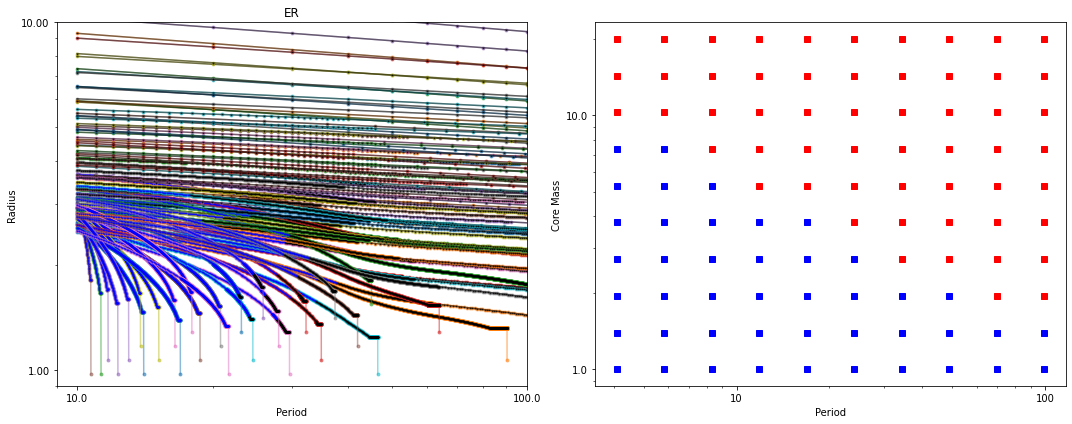

In [137]:
pl_df_dict = pl_df_dict_ChRo_ER
pl_df_more = pl_ChRo_ER_more 
track = 2

###
planets_with_RRlim = []
planets_without_RRlim = []

fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].set_title("ER")

for p in planet_ids:
    planet = pl_df_dict[p]
    lvi = planet["t"+str(track)].last_valid_index()
    planet = pl_df_dict[p].loc[:lvi]
    
    t = planet["t"+str(track)]
    R = planet["R"+str(track)]
    axs[0].plot(t, R, marker=".", alpha=0.5)
    
    mask_Elim = planet[f"Mdot_info{track}"].str.contains("Elim")
    mask_RRlim = planet[f"Mdot_info{track}"].str.contains("RRlim")
    
    axs[0].plot(t[mask_Elim], R[mask_Elim], marker="s", alpha=0.5, color="k", markersize=1)
    axs[0].plot(t[mask_RRlim], R[mask_RRlim], marker="s", alpha=0.5, color="blue", markersize=1)

    if sum(mask_RRlim) > 1:
        planets_with_RRlim.append((p, planet))
    else:
        planets_without_RRlim.append((p, planet))
    
# R = pl_ChRo_ER_more["R"+str(track)]
# P = pl_ChRo_ER_more["period"]
# axs[0].plot(P, R, marker=".", ls="None", color="b")
ylim = axs[0].get_ylim()
axs[0].set_ylim(0.9, 10)
axs[0].set_xlim(9, 100)
axs[0].set_ylabel("Radius")


core_mass = [pl_df_more.loc[p[0]]["core_mass"] for p in planets_without_RRlim]
P = [pl_df_more.loc[p[0]]["period"] for p in planets_without_RRlim]
axs[1].plot(P, core_mass, marker="s", color="red", ls="None")

core_mass = [pl_df_more.loc[p[0]]["core_mass"] for p in planets_with_RRlim]
P = [pl_df_more.loc[p[0]]["period"] for p in planets_with_RRlim]
axs[1].plot(P, core_mass, marker="s", color="blue", ls="None")

axs[1].set_ylabel("Core Mass")

for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Period")

    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

plt.tight_layout();

In [ ]:
[for p in planets_with_RRlim]]

In [121]:
pl_df_more.loc[p]["core_mass"]

20.000000000000004

In [118]:
planets_with_RRlim[0]
#pl_df_more.loc[p]["core_mass"]

('planet_031',
         t1        M1        R1           Lx1 Mdot_info1     t2        M2  \
 0    10.00  1.004627  2.627469  7.308575e+29      RRlim  10.00  1.004627   
 1    10.01  1.004616  2.625615  7.295799e+29      RRlim  10.01  1.004610   
 2    10.02  1.004605  2.623763  7.283057e+29      RRlim  10.02  1.004593   
 3    10.03  1.004594  2.621913  7.270351e+29      RRlim  10.03  1.004576   
 4    10.04  1.004583  2.620065  7.257680e+29      RRlim  10.04  1.004559   
 ..     ...       ...       ...           ...        ...    ...       ...   
 402  14.02  1.001503  2.002477  4.045263e+29      RRlim  14.02  1.000024   
 403  14.03  1.001498  2.001103  4.040217e+29      RRlim  14.03  1.000018   
 404  14.04  1.001492  1.999729  4.035181e+29      RRlim  14.04  1.000011   
 405  14.05  1.001487  1.998356  4.030155e+29      RRlim  14.05  1.000005   
 406  14.06  1.001482  1.996983  4.025138e+29      RRlim  14.06  1.000000   
 
            R2           Lx2 Mdot_info2     t3        M3   

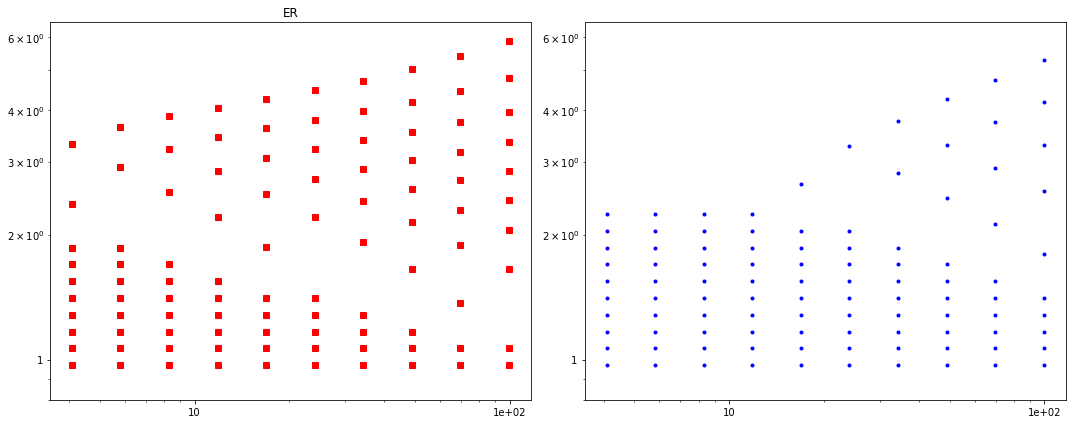

In [149]:
track = 3

fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].set_title("ER")
R = pl_ChRo_ER_more["R"+str(track)]
P = pl_ChRo_ER_more["period"]
axs[0].plot(P, R, marker="s", ls="None", color="red")

R = pl_ChRo_RR_more["R"+str(track)]
P = pl_ChRo_RR_more["period"]
axs[1].plot(P, R, marker=".", ls="None", color="blue")

# R = pl_ChRo_ER_more["R"+str(track)]
# P = pl_ChRo_ER_more["period"]
# axs[0].plot(P, R, marker=".", ls="None", color="b")
ylim = axs[0].get_ylim()
for ax in axs:
    ax.set_ylim(0.8, 6.5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    for axis in [ax.xaxis, ax.yaxis]: 
        formatter = FuncFormatter(lambda y, _: '{:.2g}'.format(y)) 
        axis.set_major_formatter(formatter)
plt.tight_layout();

In [ ]:
# here I deleted some stuff accidentally

# Integrated Lx/Lxuv - difference between tracks smaller for Jack12 tracks!

1 1.5741150928202832e+43
2 1.8753626596078872e+43
3 2.9447779455544315e+43
1 8.155909630213012e+42
2 1.091517228261945e+43
3 2.0998311195651873e+43


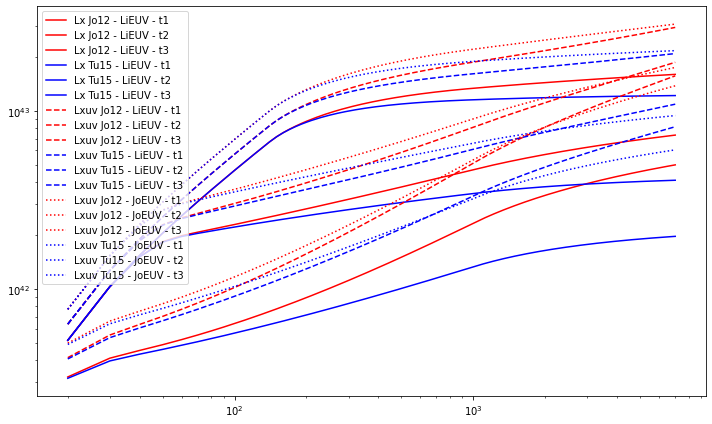

In [161]:
import scipy
def integrate_L(t, L):
    """ t in Myr"""
    t_sec = t * (1e3 * 365 * 24 * 60 * 50) # sec
    #Lx_tot = simps(x=t_sec, y=L)
    Lx_tot = scipy.integrate.trapz(x=t_sec, y=L)
    Lx_tot = scipy.integrate.cumtrapz(x=t_sec, y=L)
    return Lx_tot

fig, ax = plt.subplots(figsize=(10,6))

# Lx track
df = pl_df_dict_ChRo_Li_J12[planet]
for i in range(1,4):
    Lxuv = df["Lx"+str(i)]
    ax.plot(df["t"+str(i)][1:], integrate_L(t=df["t"+str(i)], L=Lxuv), ls="-", color="red", label="Lx Jo12 - LiEUV - t"+str(i))
    #print(i, integrate_L(t=df["t"+str(i)], L=Lxuv)[-1])

df = pl_df_dict_ChRo_Li_Tu15[planet]
for i in range(1,4):
    Lxuv = df["Lx"+str(i)]
    ax.plot(df["t"+str(i)][1:], integrate_L(t=df["t"+str(i)], L=Lxuv), ls="-", color="blue", label="Lx Tu15 - LiEUV - t"+str(i))
    #print(i, integrate_L(t=df["t"+str(i)], L=Lxuv)[-1])

# Lxuv tracks Linsky EUV
df = pl_df_dict_ChRo_Li_J12[planet]
for i in range(1,4):
    Lxuv = l_xuv_all(df["Lx"+str(i)], relation='Linsky', mstar=1.0)
    ax.plot(df["t"+str(i)][1:], integrate_L(t=df["t"+str(i)], L=Lxuv), ls="--", color="red", label="Lxuv Jo12 - LiEUV - t"+str(i))
    print(i, integrate_L(t=df["t"+str(i)], L=Lxuv)[-1])

df = pl_df_dict_ChRo_Li_Tu15[planet]
for i in range(1,4):
    Lxuv = l_xuv_all(df["Lx"+str(i)], relation='Linsky', mstar=1.0)
    ax.plot(df["t"+str(i)][1:], integrate_L(t=df["t"+str(i)], L=Lxuv), ls="--", color="blue", label="Lxuv Tu15 - LiEUV - t"+str(i))
    print(i, integrate_L(t=df["t"+str(i)], L=Lxuv)[-1])
    
# Lxuv tracks Johnstone EUV  
df = pl_df_dict_ChRo_Jo_J12[planet]
for i in range(1,4):
    Lxuv = l_xuv_all(df["Lx"+str(i)], relation='Johnstone', mstar=1.0)
    ax.plot(df["t"+str(i)][1:], integrate_L(t=df["t"+str(i)], L=Lxuv), ls=":", color="red", label="Lxuv Jo12 - JoEUV - t"+str(i))
    #print(i, integrate_L(t=df["t"+str(i)], L=Lxuv)[-1])
    
df = pl_df_dict_ChRo_Jo_Tu15[planet]
for i in range(1,4):
    Lxuv = l_xuv_all(df["Lx"+str(i)], relation='Johnstone', mstar=1.0)
    ax.plot(df["t"+str(i)][1:], integrate_L(t=df["t"+str(i)], L=Lxuv), ls=":", color="blue", label="Lxuv Tu15 - JoEUV - t"+str(i))
    #print(i, integrate_L(t=df["t"+str(i)], L=Lxuv)[-1])

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.tight_layout();

In [162]:
diff_Ja12 = 1.6046941516169302e+43/4.981498954631516e+42
diff_Tu15 = 1.219990122988276e+43/1.9773863437401413e+42
print(f"integr. Lx: Jack12 track3/track1 = {diff_Ja12:.2f}, Tu15 track3/track1 = {diff_Tu15:.2f}")

diff_Ja12 = 3.072882719910741e+43/1.38421418984009e+43
diff_Tu15 = 2.1807648998318997e+43/6.048394831227742e+42
print(f"integr. Lxuv (Johnstone): Jack12 track3/track1 = {diff_Ja12:.2f}, Tu15 track3/track1 = {diff_Tu15:.2f}")

diff_Ja12 = 2.9447779455544315e+43/1.5741150928202832e+43
diff_Tu15 = 2.0998311195651873e+43/8.155909630213012e+42
print(f"integr. Lxuv (Linsky): Jack12 track3/track1 = {diff_Ja12:.2f}, Tu15 track3/track1 = {diff_Tu15:.2f}")

integr. Lx: Jack12 track3/track1 = 3.22, Tu15 track3/track1 = 6.17
integr. Lxuv (Johnstone): Jack12 track3/track1 = 2.22, Tu15 track3/track1 = 3.61
integr. Lxuv (Linsky): Jack12 track3/track1 = 1.87, Tu15 track3/track1 = 2.57


# Population results

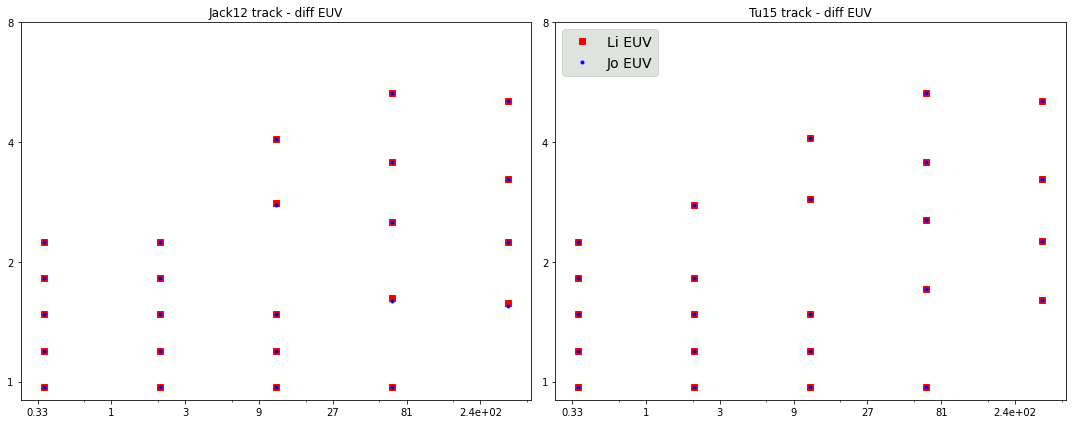

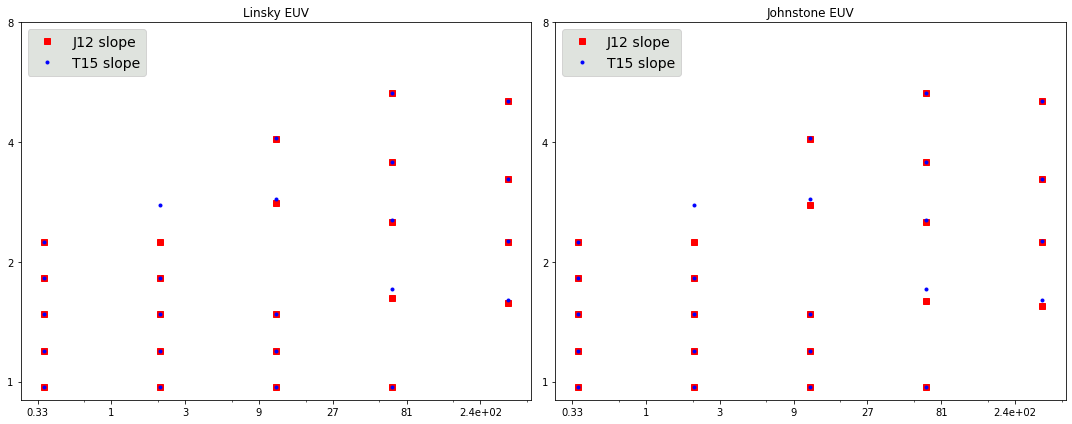

In [174]:
track = 3

fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].set_title("Jack12 track - diff EUV")
R = pl_ChRo_Li_J12_more["R"+str(track)]
P = pl_ChRo_Li_J12_more["period"]
axs[0].plot(P, R, marker="s", ls="None", color="red")
R = pl_ChRo_Jo_J12_more["R"+str(track)]
P = pl_ChRo_Jo_J12_more["period"]
axs[0].plot(P, R, marker=".", ls="None", color="b")
ylim = axs[0].get_ylim()
axs[0].set_ylim(0.9, 8)

axs[1].set_title("Tu15 track - diff EUV")
R = pl_ChRo_Li_Tu15_more["R"+str(track)]
P = pl_ChRo_Li_Tu15_more["period"]
axs[1].plot(P, R, marker="s", ls="None", color="r", label="Li EUV")
R = pl_ChRo_Jo_Tu15_more["R"+str(track)]
P = pl_ChRo_Jo_Tu15_more["period"]
axs[1].plot(P, R, marker=".", ls="None", color="b", label="Jo EUV")
axs[1].set_ylim(0.9, 8)
axs[1].legend(fontsize=14, facecolor="xkcd:light grey")

for ax in axs:
    ax.set_xscale("log", base=3)
    ax.set_yscale("log", base=2)
    for axis in [ax.xaxis, ax.yaxis]: 
        formatter = FuncFormatter(lambda y, _: '{:.2g}'.format(y)) 
        axis.set_major_formatter(formatter)
plt.tight_layout();


fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].set_title("Linsky EUV")
R = pl_ChRo_Li_J12_more["R"+str(track)]
P = pl_ChRo_Li_J12_more["period"]
axs[0].plot(P, R, marker="s", ls="None", color="red", label="J12 slope")
R = pl_ChRo_Li_Tu15_more["R"+str(track)]
P = pl_ChRo_Li_Tu15_more["period"]
axs[0].plot(P, R, marker=".", ls="None", color="b", label="T15 slope")
ylim = axs[0].get_ylim()
axs[0].set_ylim(0.9, 8)
axs[0].legend(fontsize=14, facecolor="xkcd:light grey")

axs[1].set_title("Johnstone EUV")
R = pl_ChRo_Jo_J12_more["R"+str(track)]
P = pl_ChRo_Jo_J12_more["period"]
axs[1].plot(P, R, marker="s", ls="None", color="r", label="J12 slope")
R = pl_ChRo_Jo_Tu15_more["R"+str(track)]
P = pl_ChRo_Jo_Tu15_more["period"]
axs[1].plot(P, R, marker=".", ls="None", color="b", label="T15 slope")
axs[1].set_ylim(0.9, 8)
axs[1].legend(fontsize=14, facecolor="xkcd:light grey")

for ax in axs:
    ax.set_xscale("log", base=3)
    ax.set_yscale("log", base=2)
    for axis in [ax.xaxis, ax.yaxis]: 
        formatter = FuncFormatter(lambda y, _: '{:.2g}'.format(y)) 
        axis.set_major_formatter(formatter)
plt.tight_layout();

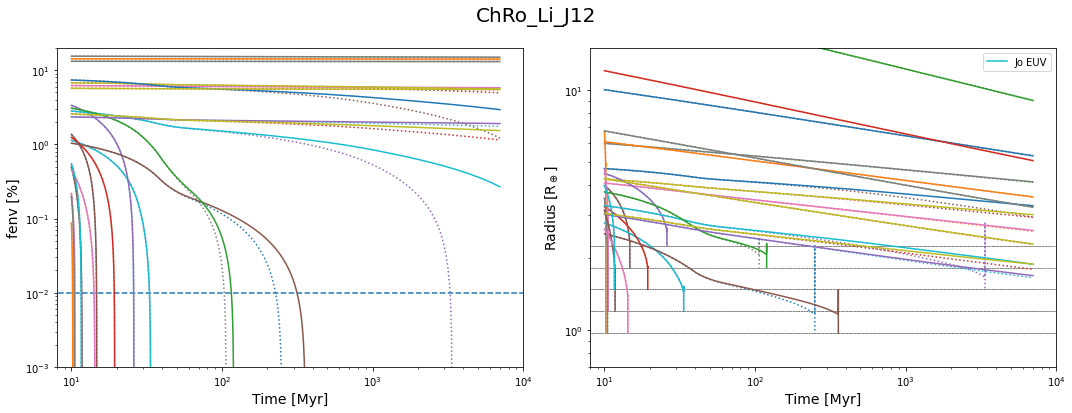

In [182]:
i = 2

fig, axs = plt.subplots(1,2, figsize=(15,6))
fig.suptitle("ChRo_Li_J12 vs Tu15", fontsize=20)   
for pl in list(pl_df_dict_ChRo_Li_J12.keys())[::1]:
    df_pl = pl_df_dict_ChRo_Li_J12[pl]
    fenv2 = ((df_pl["M"+str(i)] - pl_ChRo_Li_J12.loc[pl]["core_mass"]) / df_pl["M"+str(i)]) * 100
    axs[0].plot(df_pl["t"+str(i)], fenv2, ls=":", marker="None")
    
    l2, = axs[1].plot(df_pl["t"+str(i)], df_pl["R"+str(i)], ls=":", marker="None", label="ChRo16 Li_J12")
    xlim = axs[1].get_xlim()
    axs[1].hlines(plmoChRo16.calculate_core_radius(pl_ChRo_Li_J12.loc[pl]["core_mass"]), xlim[0], xlim[1], ls="--", lw=0.5, color="grey")
    
for pl in list(pl_df_dict_ChRo_Li_Tu15.keys())[::1]:
    df_pl = pl_df_dict_ChRo_Li_Tu15[pl]
    fenv2 = ((df_pl["M"+str(i)] - pl_ChRo_Li_Tu15.loc[pl]["core_mass"]) / df_pl["M"+str(i)]) * 100
    axs[0].plot(df_pl["t"+str(i)], fenv2, ls="-", marker="None")
    
    l2, = axs[1].plot(df_pl["t"+str(i)], df_pl["R"+str(i)], ls="-", marker="None", label="ChRo16 Li_T15")
    xlim = axs[1].get_xlim()
    #axs[1].hlines(plmoChRo16.calculate_core_radius(pl_ChRo_Li_Tu15.loc[pl]["core_mass"]), xlim[0], xlim[1], ls="--", lw=0.5, color="grey")
    

axs[0].hlines(1e-2, xlim[0], xlim[1], ls="--")
axs[0].set_ylim(1e-3, 20)
axs[0].set_ylabel("fenv [%]", size=14)
axs[1].legend([l2], ["Jo EUV"])

#axs[1].legend(fontsize=12)
axs[1].set_ylim(0.7, 15)
axs[1].set_ylabel("Radius [R$_\oplus$]", size=14)
for ax in axs:
    ax.set_xlim(8,1e4)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [Myr]", size=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]);  

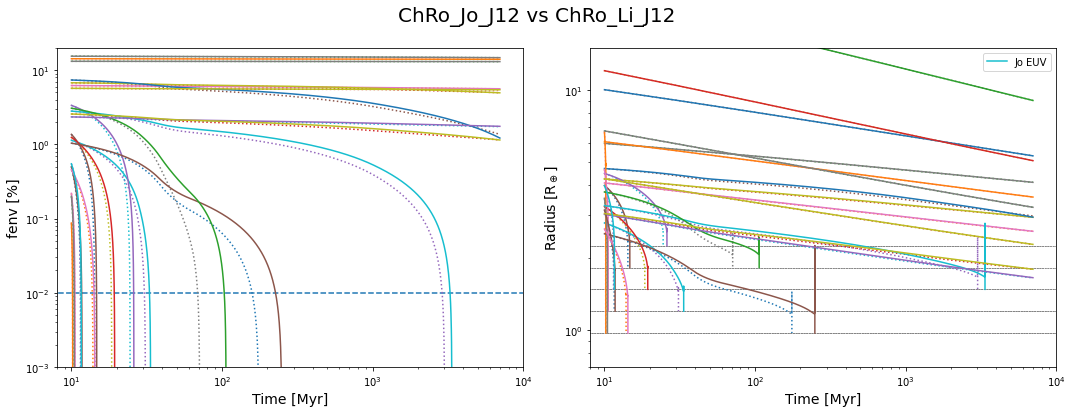

In [184]:
i = 2

fig, axs = plt.subplots(1,2, figsize=(15,6))
fig.suptitle("ChRo_Jo_J12 vs ChRo_Li_J12", fontsize=20)   
for pl in list(pl_df_dict_ChRo_Jo_J12.keys())[::1]:
    df_pl = pl_df_dict_ChRo_Jo_J12[pl]
    fenv2 = ((df_pl["M"+str(i)] - pl_ChRo_Jo_J12.loc[pl]["core_mass"]) / df_pl["M"+str(i)]) * 100
    axs[0].plot(df_pl["t"+str(i)], fenv2, ls=":", marker="None")
    
    l2, = axs[1].plot(df_pl["t"+str(i)], df_pl["R"+str(i)], ls=":", marker="None", label="ChRo16 Li_J12")
    xlim = axs[1].get_xlim()
    axs[1].hlines(plmoChRo16.calculate_core_radius(pl_ChRo_Jo_J12.loc[pl]["core_mass"]), xlim[0], xlim[1], ls="--", lw=0.5, color="grey")
    
for pl in list(pl_df_dict_ChRo_Li_J12.keys())[::1]:
    df_pl = pl_df_dict_ChRo_Li_J12[pl]
    fenv2 = ((df_pl["M"+str(i)] - pl_ChRo_Li_J12.loc[pl]["core_mass"]) / df_pl["M"+str(i)]) * 100
    axs[0].plot(df_pl["t"+str(i)], fenv2, ls="-", marker="None")
    
    l2, = axs[1].plot(df_pl["t"+str(i)], df_pl["R"+str(i)], ls="-", marker="None", label="ChRo16 Li_T15")
    xlim = axs[1].get_xlim()
    #axs[1].hlines(plmoChRo16.calculate_core_radius(pl_ChRo_Li_Tu15.loc[pl]["core_mass"]), xlim[0], xlim[1], ls="--", lw=0.5, color="grey")
    

axs[0].hlines(1e-2, xlim[0], xlim[1], ls="--")
axs[0].set_ylim(1e-3, 20)
axs[0].set_ylabel("fenv [%]", size=14)
axs[1].legend([l2], ["Jo EUV"])

#axs[1].legend(fontsize=12)
axs[1].set_ylim(0.7, 15)
axs[1].set_ylabel("Radius [R$_\oplus$]", size=14)
for ax in axs:
    ax.set_xlim(8,1e4)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [Myr]", size=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]);  

# FAZIT: the shape (Lx_sat level and Lx-decay slope) has a greater influence than the EUV estimation method (e.g. Linsky vs. Johnstone)

-------------------------------------------------------------------------------------------------------------------------------------------

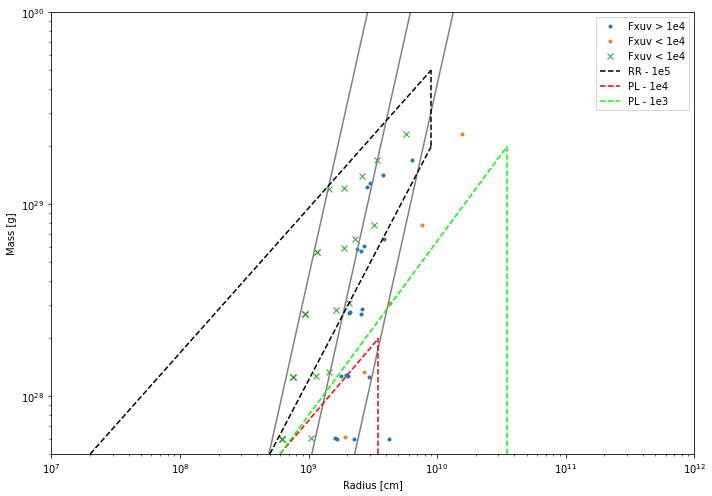

In [181]:
def mass_for_const_rho(rho, radius):
    return rho * (4./3 * np.pi * radius**3)
    
    

track = 2
df = pl_ChRo_Jo_J12_more

fig, ax = plt.subplots(figsize=(10,7))

Lxuv = [l_xuv_all(df["Lx0_"+str(track)].loc[i], relation='Johnstone', mstar=df["mass_star"].loc[i]) for i in df.index]
F_x = flux_at_planet(df["Lx0_"+str(track)], df["a"])
F_xuv = flux_at_planet(Lxuv, df["a"])
mask1e4 = F_xuv > 1e4
ax.plot(df["radius"][mask1e4]*const.R_earth.cgs.value, df["mass"][mask1e4]*const.M_earth.cgs.value, marker='.', ls="None", label='Fxuv > 1e4')
ax.plot(df["radius"][~mask1e4]*const.R_earth.cgs.value, df["mass"][~mask1e4]*const.M_earth.cgs.value, marker='.', ls="None", label='Fxuv < 1e4')

ax.plot(df["R"+str(track)]*const.R_earth.cgs.value, df["M"+str(track)]*const.M_earth.cgs.value, marker='x', ls="None", label='Fxuv < 1e4')


r_arr = np.logspace(7, 11)
ax.plot(r_arr, mass_for_const_rho(10., r_arr), color='grey')
ax.plot(r_arr, mass_for_const_rho(1., r_arr), color='grey')
ax.plot(r_arr, mass_for_const_rho(0.1, r_arr), color='grey')

#ax.hlines(5*1e29, 1e7, 1e12, color='k', ls='--', lw=1.5)
ax.plot([5*1e8, 9*1e9], [5*1e27, 2*1e29], color='k', ls='--', lw=1.5)
ax.plot([2*1e7, 9*1e9], [5*1e27, 5*1e29], color='k', ls='--', lw=1.5)
ax.plot([9*1e9, 9*1e9], [2*1e29, 5*1e29], color='k', ls='--', lw=1.5, label='RR - 1e5')

ax.plot([6*1e8, 3.5*1e9], [5*1e27, 2*1e28], color='red'  , ls='--', lw=1.5)
ax.plot([3.5*1e9, 3.5*1e9], [5*1e27, 2*1e28], color='red', ls='--', lw=1.5, label='PL - 1e4')
ax.plot([6*1e8, 3.5*1e10], [5*1e27, 2*1e29], color='lime', ls='--', lw=1.5)
ax.plot([3.5*1e10, 3.5*1e10], [5*1e27, 2*1e29], color='lime', ls='--', lw=1.5, label='PL - 1e3')


ax.set_ylim(0.5*1e28, 1e30)
ax.set_xlim(1e7, 1e12)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylabel('Mass [g]')
ax.set_xlabel('Radius [cm]')
plt.tight_layout();